### Example script for using IBS to estimate parameters
In this example, we fit some simple orientation discrimination data using IBS, BADS and PyVBMC.

First, we simulate a synthetic dataset to fit.

In [1]:
import numpy as np
import numpy.random as npr
from pybads.bads import BADS
from pyvbmc import VBMC
from ibs import IBS
from psycho_gen import psycho_gen
from psycho_nll import psycho_nll

In [2]:
fun = psycho_gen
num_trials = 600
eta = np.log(1)  # Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03  # Fake subject lapse rate
# Generating parameter vector
params = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
design_matrix = 3 * npr.rand(num_trials)
# Generate fake subject responses
response_matrix = psycho_gen(params, design_matrix)

# We set the lower/upper bounds for the parameters (in particular, note that
# we set a nonzero lower bound for the lapse rate)
lb = np.array([np.log(0.1), -2, 0.01])
ub = np.array([np.log(10), 2, 1])

# We also set the "plausible" lower/upper bounds representing where we
# would expect to find most parameters (this is not a prior, it just
# identifies a region e.g. for the starting points)
plb = np.array([np.log(0.2), -1, 0.02])
pub = np.array([np.log(5), 1, 0.15])

### Maximum-likelihood estimation (MLE)

We fit the data via maximum-likelihood estimation using Bayesian Adaptive  Direct Search (BADS), a particularly effective optimization algorithm for noisy target functions.

We define the negative log-likelihood function via a call to IBS.
We set 10 reps for the IBS estimator. We also tell IBS to return as a second output the standard deviation  of the estimate (as opposed to the variance).

In [3]:
ibs = IBS(
    fun,
    response_matrix,
    design_matrix,
    vectorized=True,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)
target = lambda theta: ibs(theta, additional_output="std")

# As a starting point for the optimization, we draw a sample inside the
# plausible box (in practice you should use multiple restarts!)
theta0 = plb + npr.rand(3) * (pub - plb)

# We inform BADS that IBS returns noise estimate (standard deviation) as second output
bads_options = {"specify_target_noise": True, "uncertainty_handling": True}

In [4]:
bads_exact = BADS(
    lambda theta: psycho_nll(theta, design_matrix, response_matrix),
    theta0,
    lb,
    ub,
    plb,
    pub,
)
theta_exact = bads_exact.optimize()

bads = BADS(target, theta0, lb, ub, plb, pub, options=bads_options)
theta_ibs = bads.optimize()

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         265.287               1                                 Uncertainty test
     0           6         226.837               1         Initial mesh            Initial points
     0          11         226.837             0.5         Refine grid             Train
     1          12           214.6             0.5     Successful search (ES-wcm)        
     1          17         210.358             0.5     Successful search (ES-wcm)        
     1          21          207.65             0.5     Successful search (ES-wcm)        
     1          26         205.634             0.5     Successful search (ES-ell)        
     1          27          205.01             0.5     Successful search (ES-ell)        
     1          28         204.733             0.5     Incremental search (ES-ell)        
     1          30 

c:\Users\julia\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1805: RuntimeWarning: invalid value encountered in subtract
  x = x - np.median(x)


     4          63          204.42        0.015625         Refine grid             Train
     5          72          204.42      0.00390625         Refine grid             Train
Optimization terminated: change in the function value less than options.TolFun.
Function value at minimum: 204.4195882702759

Beginning optimization of a STOCHASTIC objective function (specified noise)

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         267.139         3.89226               1                                  
     0          33         209.438         3.89226               1          Initial mesh            Initial points
     0          38         209.438         3.97429             0.5          Refine grid             Train
     1          39         207.558         1.88719             0.5      Successful search (ES-wcm)        
     1          43         205.913         1.67406             0.5      Successful

##### Analysis of results

In [12]:
theta_estimated = theta_ibs["x"]
print("Returned maximum-likelihood solutions with different methods:")
print("Analitical log-likelihood: ", theta_exact["x"])
print("IBS log-likelihood: ", theta_estimated)
print("Data generating parameters: ", params)

neg_logl_ibs, neg_logl_std = ibs(theta_estimated, additional_output="std", num_reps=100)
neg_logl_exact = psycho_nll(theta_exact["x"], design_matrix, response_matrix)

print(
    f"Estimated log-likelihood at the IBS-found solution: {-neg_logl_ibs:.2f} +/- {neg_logl_std:.2f} (exact value: {-psycho_nll(theta_estimated, design_matrix, response_matrix):.2f})."
)
# We also evaluate the MLE found exactly
print(f"Log-likelihood at the exact-found solution: {-neg_logl_exact:.2f}.")

# Note that even the exact MLE will differ from the true data-generating
# parameters due to finiteness of the dataset (we expect to recover the
# true data generating parameters in the limit num_trials -> infinity)

Returned maximum-likelihood solutions with different methods:
Analitical log-likelihood:  [0.07711235 0.070755   0.01000046]
IBS log-likelihood:  [-0.13031208  0.07638752  0.09481983]
Data generating parameters:  [0.   0.2  0.03]
Estimated log-likelihood at the IBS-found solution: -210.32 +/- 1.27 (exact value: -210.34).
Log-likelihood at the exact-found solution: -204.42.


### Bayesian Posterior Estimation

We now fit the same data via a method that computes the Bayesian posterior over model parameters, called Variational Bayesian Monte Carlo (VBMC).

For VBMC, we need to return the POSITIVE log-likelihood as first output, and the standard deviation (not variance!) of the estimate as second output.

In [10]:
from pyvbmc.priors import Trapezoidal

log_likelihood = lambda theta: ibs(
    theta, additional_output="std", num_reps=100, return_positive=True
)
# num_reps = 100 to try and have a SD ~ 1 (and below 3)

# Set the lower/upper bounds for the parameters
lb = np.array([np.log(0.1), -2, 0.01])
ub = np.array([np.log(10), 2, 1])

# Set the "plausible" lower/upper bounds
plb = np.array([np.log(0.2), -1, 0.02])
pub = np.array([np.log(5), 1, 0.2])

# Trapezoidal or “tent” prior over the parameters (flat between PLB and PUB, and linearly decreasing to 0 towards LB and UB)
prior = Trapezoidal(lb, plb, pub, ub)
log_prior = lambda x: prior.log_pdf(x)

# Here we could use as starting point the result of a run of BADS
theta0 = 0.5 * (plb + pub)

options = {"specify_target_noise": True}
vbmc = VBMC(
    log_likelihood, theta0, lb, ub, plb, pub, log_prior=log_prior, options=options
)

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).


In [11]:
# run VBMC

np.random.seed(42)
vp, results = vbmc.optimize()

Beginning variational optimization assuming NOISY observations of the log-joint
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -223.56         4.00      4023.83        2        inf     start warm-up
     1         15        -210.88         5.80       114.27        2        inf     
     2         20        -213.36         0.76        12.12        2        236     
     3         25        -213.63         0.59         0.66        2       13.5     
     4         30        -213.93         0.45         0.03        2       1.21     
     5         35        -214.01         0.38         0.05        2       1.48     
     6         40        -213.95         0.34         0.08        2       1.96     end warm-up
     7         45        -213.88         0.32         0.11        2       2.49     
     8         50        -213.96         0.29         0.01        2      0.484     
     9         55        -213.98         0.25     

c:\Users\julia\anaconda3\lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    17         95        -213.82         0.19         0.00       15      0.238     
    18        100        -213.79         0.18         0.01       15      0.431     
    19        105        -213.82         0.18         0.00       13      0.276     
    20        110        -213.76         0.18         0.01       13      0.348     
    21        115        -213.79         0.17         0.00       14      0.204     rotoscale, undo rotoscale
    22        120        -213.80         0.17         0.00       15      0.222     stable
   inf        120        -213.78         0.17         0.01       50      0.222     finalize
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -213.776 +/-0.167.


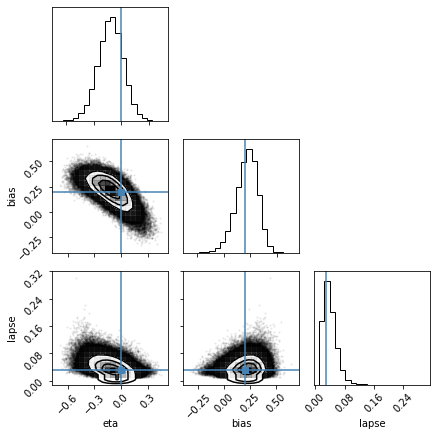

In [12]:
vp.plot(
    n_samples=int(3e5),
    plot_style={"corner": {"truths": params, "labels": ["eta", "bias", "lapse"]}},
);

The blue lines represent the true generating parameters for the synthetic dataset.